# Experiment 05: MILLORA DE LA U-NET (v2) per a la segmentació de grapes

Aquest quadern serveix com a exemple per a iniciar-se a les xarxes neuronals. El que veurem serà l'estructura principal d'un quader de Jupyter, com definir un model de xarxa neuronal i fer-ne l'entrenament. Primer de tot, és una bona pràctica reservar la primera cel·la de codi per a fer tots els imports necessaris. Després, ja escriurem el codi.

In [1]:
import cv2
import glob
import numpy 
import os
import skimage

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from matplotlib import pyplot as plt
from numpy.random import seed
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend 
from tensorflow.keras.optimizers import *
from typing import Tuple, List

os.environ["CUDA_VISIBLE_DEVICES"]="1"
seed(1)

2024-07-01 16:46:05.825484: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


## Lectura del *Redscar Dataset* i implementació del generador

Les imatges que s'empraran per a fer l'entrenament les anirem carregant a mesura que la xarxa les demani, per evitar carregar tot el dataset en memòria. Primer de tot, establirem la ruta del dataset.

In [2]:
REDSCAR_DATASET = "/home/marc/UIB_EXPERIMENTS/REDSCAR"
REDSCAR_DATASET_TRAIN = os.path.join(REDSCAR_DATASET, "SUBSETS", "MACHINE_LEARNING_DATASET", "train")
REDSCAR_DATASET_TEST = os.path.join(REDSCAR_DATASET, "SUBSETS", "MACHINE_LEARNING_DATASET", "test")

In [3]:
def neural_network_generator(img_path: str, gt_path: str, size: Tuple[int, int], batch_size: int):
    images = sorted(glob.glob(img_path))
    masks = sorted(glob.glob(gt_path))
    
    assert len(images) == len(masks), "The number of images and masks to be used must match."
    
    batch_img = []
    batch_mask = []
    idx = 1
    
    while(True):
        path_img = images[idx % len(images)]
        path_mask = masks[idx % len(images)]
    
        img = cv2.imread(path_img, 1)
        mask = cv2.imread(path_mask, 0)
        
        img = skimage.transform.resize(img, (size[0], size[1], 3))
        mask = cv2.resize(mask, size)
        
        mask = mask/255
        mask[mask < 0.5] = 0
        mask[mask >= 0.5] = 1
            
        batch_img.append(img)
        batch_mask.append(mask)
        
        if (idx%(batch_size) == 0) and idx != 0:            
            batch_img = numpy.array(batch_img)
            batch_mask = numpy.array(batch_mask)
            
            yield batch_img, batch_mask
            
            batch_img = []
            batch_mask = []
        idx += 1
        
def validation_generator(img_path: str, gt_path: str, size: Tuple[int, int]):
    images_names = sorted(glob.glob(img_path))
    masks_names = sorted(glob.glob(gt_path))
    
    images = []
    masks = []
    
    for image_idx in range(len(images_names)):
        path_img = images_names[image_idx]
        path_mask = masks_names[image_idx]
    
        img = cv2.imread(path_img, 1)
        mask = cv2.imread(path_mask, 0)
        
        img = skimage.transform.resize(img, (size[0], size[1], 3))
        mask = cv2.resize(mask, size)
        
        mask = mask/255
        mask[mask < 0.5] = 0
        mask[mask >= 0.5] = 1
        
        images.append(img)
        masks.append(mask)
    
    return (numpy.array(images), numpy.array(masks))

In [4]:
IMAGES_TEST, GT_TEST = validation_generator(img_path=REDSCAR_DATASET_TEST+'/IMAGES/*.png', 
                       gt_path=REDSCAR_DATASET_TEST+'/GT_STAPLES_MASK/*.png', 
                       size=(256, 256))

(5, 256, 256, 3) (5, 256, 256)


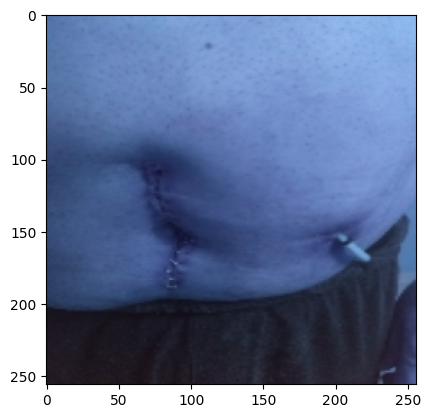

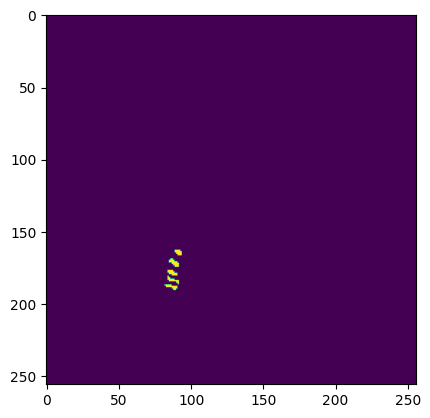

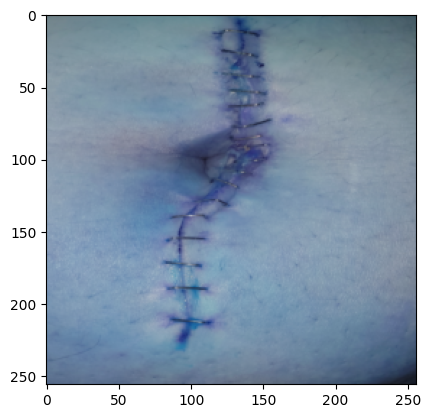

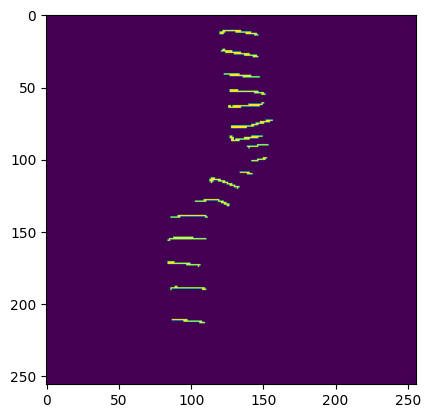

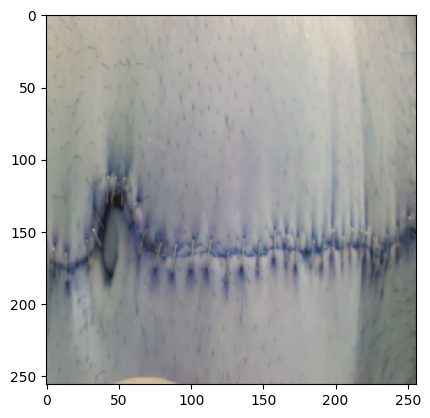

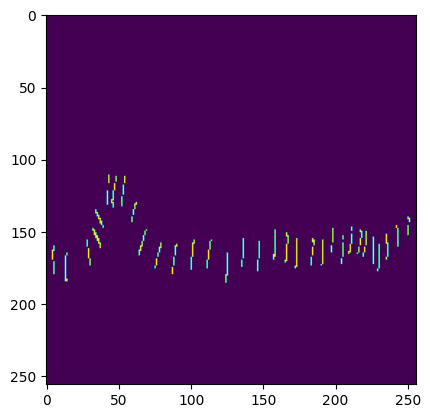

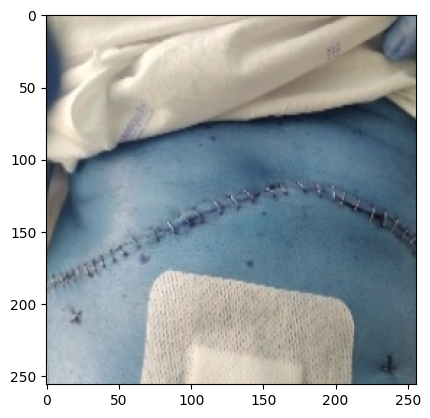

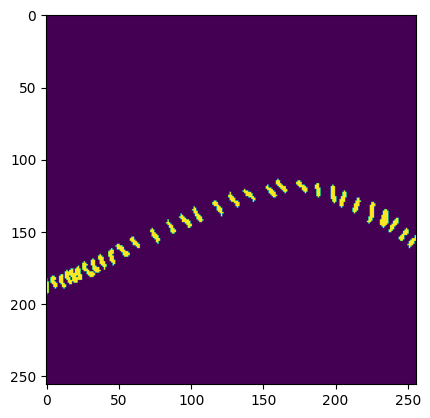

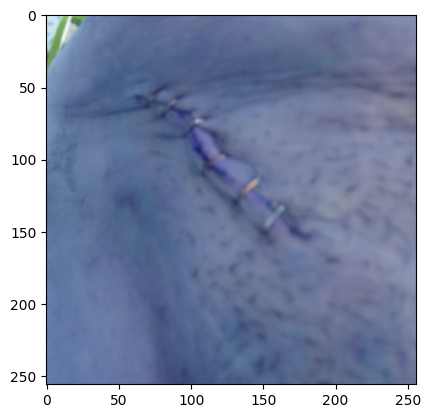

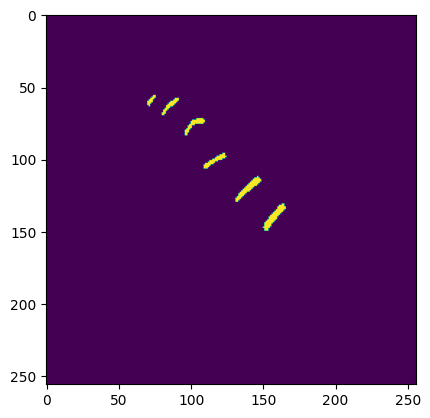

In [5]:
BATCH_SIZE = 5
for image_batch, mask_batch in neural_network_generator(img_path=REDSCAR_DATASET_TRAIN+'/IMAGES/*.png', 
                                                        gt_path=REDSCAR_DATASET_TRAIN+'/GT_STAPLES_MASK/*.png', 
                                                        size=(256, 256), 
                                                        batch_size=BATCH_SIZE):
    print(image_batch.shape, mask_batch.shape)
    for i in range(0, BATCH_SIZE):
        plt.imshow(image_batch[i,:,:,:])
        plt.show()
        plt.imshow(mask_batch[i,:,:])
        plt.show()
    break

## Implementació de la UNet

L'arquitectura UNet es va proposar per primera vegada a *U-Net: Convolutional Networks for Biomedical Image Segmentation*, per Ronneberger et al. És una xarxa del tipus codificador-decodificador, i la seva arquitectura es pot veure a la següent imatge.

![alternatvie text](unet_architecture.jpg)

El que farem serà implementar una funció per als blocs de codificació (els de l'esquerra), i una funció per als blocs de decodificació (els de la dreta).

In [6]:
def encoder_block(inputs, num_filters): 
    # Convolution with 3x3 filter followed by ReLU activation 
    x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs) 
      
    # Convolution with 3x3 filter followed by ReLU activation 
    x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x) 
  
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Max Pooling with 2x2 filter 
    pooling = tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = 2)(x) 
      
    return x, pooling


def decoder_block(inputs, skip_features, num_filters): 
    
    # Upsampling with 2x2 filter
    up = tf.keras.layers.UpSampling2D(size = (2,2))(inputs)
    x = tf.keras.layers.Convolution2D(num_filters, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up)
    
    # Feature concatenation
    x = tf.keras.layers.concatenate([skip_features, x], axis = 3)
    
    # Convolution with 3x3 filter followed by ReLU activation 
    x = tf.keras.layers.Convolution2D(num_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Convolution with 3x3 filter followed by ReLU activation 
    x = tf.keras.layers.Convolution2D(num_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    return x

In [6]:
def build_unet(input_shape=Tuple[int,int,int]):
    inputs = tf.keras.layers.Input(input_shape) 
      
    # Contracting path 
    c1, p1 = encoder_block(inputs, 64) 
    c2, p2 = encoder_block(p1, 128) 
    c3, p3 = encoder_block(p2, 256) 
    c4, p4 = encoder_block(p3, 512) 
      
    # Bottleneck 
    b1 = tf.keras.layers.Conv2D(filters=1024, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(p4) 
    b1 = tf.keras.layers.BatchNormalization()(b1)
    b1 = tf.keras.layers.Conv2D(filters=1024, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(b1) 
    b1 = tf.keras.layers.BatchNormalization()(b1)
    
    # Expansive path 
    e1 = decoder_block(b1, c4, 512) 
    e2 = decoder_block(e1, c3, 256) 
    e3 = decoder_block(e2, c2, 128) 
    e4 = decoder_block(e3, c1, 64) 
      
    # Output 
    final_layer = tf.keras.layers.Convolution2D(filters=2, kernel_size=3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(e4)
    final_layer = tf.keras.layers.BatchNormalization()(final_layer)
    outputs = tf.keras.layers.Conv2D(filters=1, kernel_size=1, activation='sigmoid', padding = 'same', kernel_initializer='he_normal')(final_layer) 
      
    model = tf.keras.models.Model(inputs = inputs, outputs = outputs, name = 'U-Net') 
    return model

In [7]:
unet2 = build_unet(input_shape=(256, 256, 3)) 
unet2.summary()

2023-12-24 17:22:37.588344: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-12-24 17:22:37.637421: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
2023-12-24 17:22:37.637480: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2023-12-24 17:22:37.640098: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2023-12-24 17:22:37.642264: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2023-12-24 17:22:37.642710: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

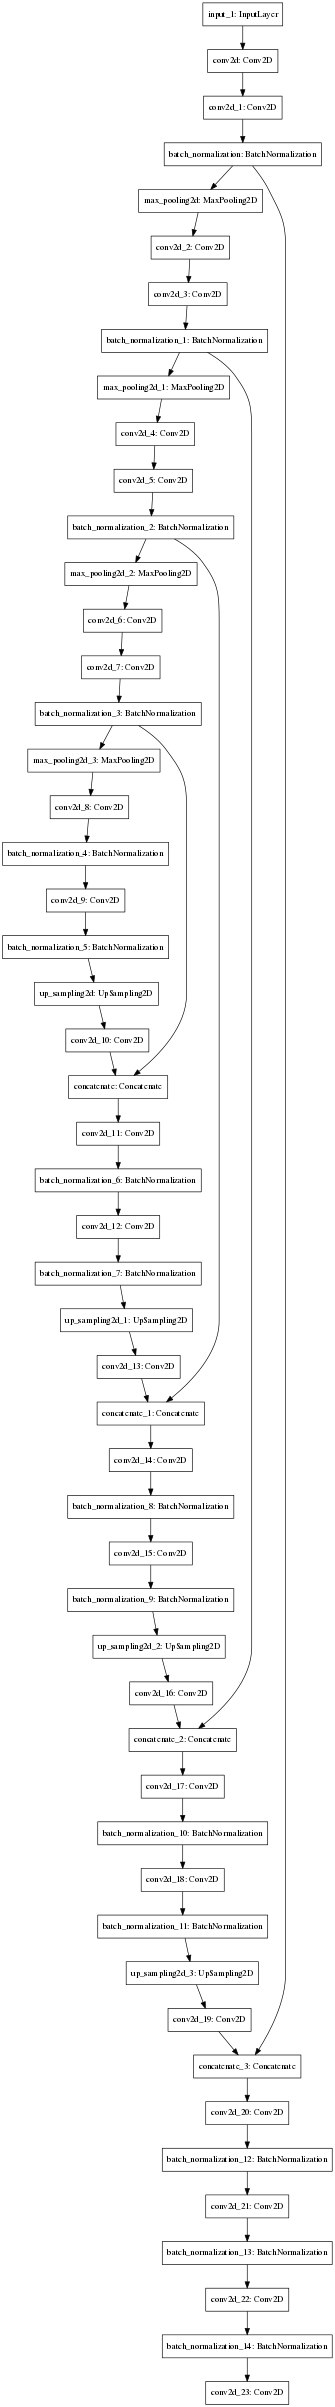

In [8]:
tf.keras.utils.plot_model(
    unet2,
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=46,
)

## Entrenament de la UNet

Ja ho tenim quasi a punt per a fer l'entrenament. Només ens queda definir la funció de pèrdua. Emprarem el coeficient de dice atès que és una mètrica emprada usualment en aquests casos.

In [7]:
def dice(y_true, y_pred):
    y_true_f = backend.flatten(y_true)
    y_pred_f = backend.flatten(y_pred)
    intersection = backend.sum(y_true_f * y_pred_f)
    return (2.* intersection+1) / (backend.sum(y_true_f) + backend.sum(y_pred_f)+1 )

def dice_loss(y_true, y_pred):
    return 1-dice(y_true, y_pred)

In [10]:
unet2.compile(optimizer=Adam(learning_rate = 3e-4), loss=dice_loss, metrics = [dice])

In [11]:
BATCH_SIZE = 5
TOTAL_IMAGES = 275
STEPS_PER_EPOCH = TOTAL_IMAGES // BATCH_SIZE 
EPOCHS = 50 #modificam aquesta respecte a la unet ferides: a ferides era 35, ara en feim 50

reduceLROnPlat = ReduceLROnPlateau(monitor='dice', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='max', cooldown=2, min_lr=1e-7)
early = EarlyStopping(monitor="dice",
                      mode="max",
                      patience=8)
CALLBACKS = [early, reduceLROnPlat]

TRAIN_GENERATOR = neural_network_generator(img_path=REDSCAR_DATASET_TRAIN+'/IMAGES/*.png', 
                                           gt_path=REDSCAR_DATASET_TRAIN+'/GT_STAPLES_MASK/*.png',
                                           size=(256, 256),
                                           batch_size=BATCH_SIZE)

In [12]:
training_history = unet2.fit(TRAIN_GENERATOR, 
                            validation_data=(IMAGES_TEST, GT_TEST),
                            epochs=EPOCHS,
                            validation_steps=2,
                            callbacks=CALLBACKS,
                            steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/50


2023-12-24 17:23:18.548250: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2023-12-24 17:23:19.347715: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


55/55 [==============================] - 328s 6s/step - loss: 0.9762 - dice: 0.0238 - val_loss: 0.9881 - val_dice: 0.0119
Epoch 2/50
55/55 [==============================] - 323s 6s/step - loss: 0.9738 - dice: 0.0262 - val_loss: 0.9886 - val_dice: 0.0114
Epoch 3/50
55/55 [==============================] - 319s 6s/step - loss: 0.9728 - dice: 0.0272 - val_loss: 0.9842 - val_dice: 0.0158
Epoch 4/50
55/55 [==============================] - 317s 6s/step - loss: 0.9714 - dice: 0.0286 - val_loss: 0.9822 - val_dice: 0.0178
Epoch 5/50
55/55 [==============================] - 319s 6s/step - loss: 0.9699 - dice: 0.0301 - val_loss: 0.9830 - val_dice: 0.0169
Epoch 6/50
55/55 [==============================] - 320s 6s/step - loss: 0.9685 - dice: 0.0315 - val_loss: 0.9689 - val_dice: 0.0310
Epoch 7/50
55/55 [==============================] - 314s 6s/step - loss: 0.9673 - dice: 0.0327 - val_loss: 0.9650 - val_dice: 0.0350
Epoch 8/50
55/55 [==============================] - 321s 6s/step - loss: 0.9657 

No basta només amb entrenar la xarxa. També hem de poder avaluar la qualitat de l'entrenament. Per això, la variable `training_history` de la cel·la anterior té aquesta informació.

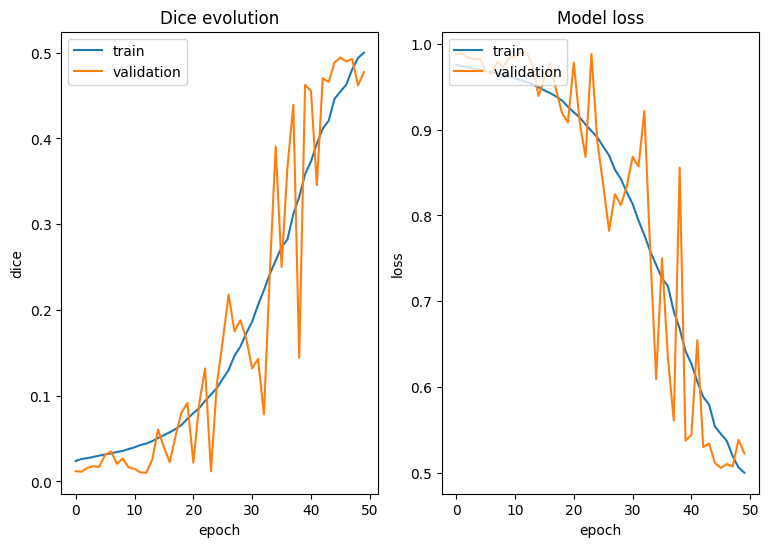

In [13]:
plt.figure(figsize=(9,6), dpi= 100, facecolor='w', edgecolor='k')

plt.subplot(1,2,1)
plt.plot(training_history.history['dice'])
plt.plot(training_history.history['val_dice'])
plt.title('Dice evolution')
plt.ylabel('dice')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# "Loss"
plt.subplot(1,2,2)
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

EXPERIMENT_PATH = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment05'
plt.savefig(EXPERIMENT_PATH+f'/unet2_grapes_rendiment.png')

**Molt important també**. Podem haver fet l'entrenament, però si en algun moment volem fer una altra prova naturalment tornar a entrenar la xarxa no és una opció, perquè perdem temps de computació en una feina que prèviament ja hem fet. Per això, podem guardar el model en un fitxer, i recuperar-lo posteriorment per a fer les prediccions que puguin fer falta. L'extensió del fitxer **sempre** ha de ser `.h5`.

In [14]:
unet2.save(os.path.join(EXPERIMENT_PATH, "unet2_grapes.h5"))

Si ara volem recuperar el model, ho farem de la següent manera. L'estat de la xarxa és idèndic a quan la vàrem guardar.

In [8]:
EXPERIMENT_PATH = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment05'
from tensorflow.keras.models import load_model
loaded_model = load_model(os.path.join(EXPERIMENT_PATH, "unet2_grapes.h5"), 
                          custom_objects={'dice_loss': dice_loss, 'dice': dice})

2024-07-01 16:48:19.572424: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2024-07-01 16:48:19.599801: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:06:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2024-07-01 16:48:19.599842: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2024-07-01 16:48:19.601496: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2024-07-01 16:48:19.602923: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2024-07-01 16:48:19.603183: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so

## Prediccions amb la UNet

Fins ara hem implementat la UNet, l'hem entrenat i hem guardat els pesos a un fitxer per a poder fer futures prediccions. Això és el que pretenem fer en aquesta secció: passar-li una imatge a la UNet, i que ens faci la predicció. És important observar un fet: quan li passam imatges amb el generador, li estem donant amb una certa mida, i la xarxa ens torna les imatges també amb una certa mida de sortida. Però clar, no totes les imatges del dataset tenen la mateixa mida, ni tampoc tenen la mateixa mida $256\times 256$ que li imposam a la xarxa. Per aquest motiu, és important establir un criteri. Com que les màscares ens determinen la posició exacta de l'objecte, farem el següent:

1. Donada una imatge sobre la que volem fer la predicció, canviar la seva mida a la dimensió d'entrada de la xarxa.
2. Calcular la predicció del model, que ens tornarà una imatge en la dimensió de sortida del mateix. Aquesta sortida serà, **en el cas de la UNet**, una imatge amb entrades dins l'interval $[0,1]$, que podem interpretar com una imatge en escala de grisos.
3. Redimensionar aquesta sortida amb les dimensions de la imatge en qüestió.
4. Binaritzar el resultat de la passa anterior.
5. Comparar amb la màscara.

Un dubte que pot sorgir és si les passes 3 i 4 es poden permutar. La resposta és que no. Si primer binaritzam, quan facem el canvi d'escala posterior la imatge resultant **no** és, en general, binària. Hem de pensar que fer un canvi d'escala aplica per darrere una sèrie de tècniques d'interpolació, que poden donar lloc a imatges en escala de grisos, que no són comparables a la passa 4 amb la màscara final.

In [9]:
def predict_image(model: tf.keras.models.Model, model_input: Tuple[int, int], image: numpy.ndarray, binary_threshold: float=0.5):
    resized_image = skimage.transform.resize(image, (model_input[0], model_input[1], 3)) #Passa 1
    prediction_raw = model.predict(numpy.array([resized_image])) # Passa 2
    
    # Passa 3
    prediction = prediction_raw[0][:,:,0]
    prediction_resized = skimage.transform.resize(prediction, (image.shape[0], image.shape[1]))
    prediction_binary_bool = prediction_resized >= binary_threshold
    prediction_binary = 255*prediction_binary_bool
    
    return prediction_binary

In [17]:
test_image_name = "0SeVHyRODnGrnAURdi8tbneiS_infection=0_capture=1_resolution=0.png"
original_image = cv2.imread(os.path.join(REDSCAR_DATASET_TEST, "IMAGES", test_image_name))
gt_image = cv2.imread(os.path.join(REDSCAR_DATASET_TEST, "GT_WOUND_MASK", test_image_name), 0)

result = predict_image(model=unet2, model_input=(256, 256), image=original_image)
# En lloc de unet també podem passar loaded_model. Són el mateix model i per tant fan la mateixa predicció.
# result = predict_image(model=unet, model_input=(256, 256), image=original_image)

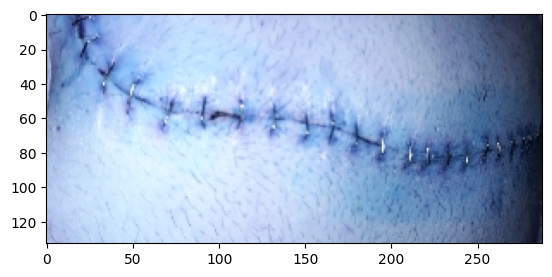

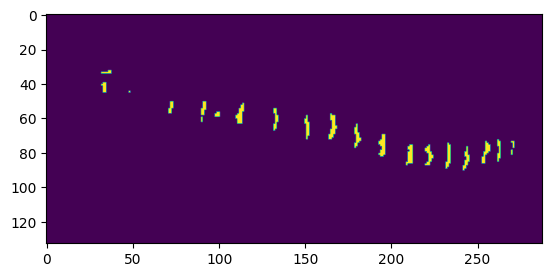

In [18]:
plt.imshow(original_image)
plt.show()

plt.imshow(result)
plt.show()

Ara implementarem dues funcions que reben per paràmetres la gt i la predicció i ens retornen la mètrica: la dice i la jaccard.

In [29]:
 def metriques_absolutes(gt_image, prediction):
    (n,m) = numpy.shape(gt_image)  
    
    if (n,m) != numpy.shape(prediction): # comprovació que les mides de la imatge de la predicció i la de la gt coincideixen
        return []
    
    [tp,fn,fp,tn] = [0,0,0,0] # si les mides coincideixen, calcularem les mètriques absolutes
    for i in range(n):
        for j in range(m):
            if gt_image[i][j]==255 and prediction[i][j]==255: 
                tp += 1
            elif gt_image[i][j]==255 and prediction[i][j]==0:
                fn += 1
            elif gt_image[i][j]==0 and prediction[i][j]==255:
                fp += 1
            elif gt_image[i][j]==0 and prediction[i][j]==0:
                tn += 1
                    
    return [tp,fn,fp,tn]

In [30]:
def dice_coefficient(gt_image, prediction):
    metriques = metriques_absolutes(gt_image, prediction)  
    
    if metriques == []:
        return []
    
    [tp,fn,fp,tn] = metriques
    # calculem el valor del coeficient de dice
    # calculem el valor del coeficient de dice
    if (2*tp + fp + fn) == 0: #això voldria dir que tots el coefs. són TN i, per tant, ho fa bé
        dice = 1
    else:
        dice = 2*tp/(2*tp + fp + fn)
        
    return [tp,fn,fp,tn,dice]

In [31]:
def jaccard_coefficient(gt_image, prediction):
    metriques = metriques_absolutes(gt_image, prediction)
    
    if metriques == []:
        return []
    
    [tp,fn,fp,tn] = metriques
    # calculem el valor del coeficient de jaccard
    if (tp + fp + fn) == 0: #com abans, la predicció és bona
        jaccard = 1
    else:
        jaccard = tp/(tp + fp + fn)
    
    return [tp,fn,fp,tn,jaccard]

Ara avaluarem les imatges de train amb ambdues mètriques:

In [32]:
noms_imatges = []
dice_imatges = []
jaccard_imatges = []
tp_imatges = []
fn_imatges = []
fp_imatges = []
tn_imatges = []

imatges_train = os.path.join(REDSCAR_DATASET_TRAIN, "IMAGES")
gt_train = os.path.join(REDSCAR_DATASET_TRAIN, "GT_STAPLES_MASK")

for nom_imatge in os.listdir(imatges_train): 
    
    noms_imatges.append(nom_imatge)
    imatge = cv2.imread(os.path.join(imatges_train,nom_imatge), 1) # en color
    gt = cv2.imread(os.path.join(gt_train,nom_imatge), 0) # escala de grisos
    #feim la predicció
    prediccio = predict_image(model=unet2, model_input=(256, 256), image=imatge)
    
    #avaluam amb cada mètrica
    dice_resultat = dice_coefficient(gt, prediccio)
    if dice_resultat != []:
        dice = dice_resultat[-1]
        dice_imatges.append(dice)
        jaccard = jaccard_coefficient(gt, prediccio)[-1]
        jaccard_imatges.append(jaccard)
        tp = dice_resultat[0]
        tp_imatges.append(tp)
        fn = dice_resultat[1]
        fn_imatges.append(fn)
        fp = dice_resultat[2]
        fp_imatges.append(fp)
        tn = dice_resultat[3]
        tn_imatges.append(tn)
        
    else:
        dice_imatges.append(None)
        jaccard_imatges.append(None)
        tp_imatges.append(None)
        fp_imatges.append(None)
        fn_imatges.append(None)
        tn_imatges.append(None)
    
import pandas as pd

# cream un DataFrame
unet2_grapes_train = pd.DataFrame({'nom': noms_imatges, 'DICE': dice_imatges, 'JACCARD': jaccard_imatges, 'TP': tp_imatges, 'FN': fn_imatges, 'FP': fp_imatges, 'TN': tn_imatges})

# el guardam com un arxiu .csv en la carpeta resultats
RESULTATS_PATH = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment05/unet2_grapes_train.csv'
unet2_grapes_train.to_csv(RESULTATS_PATH, index=False)


Farem el mateix amb les imatges de test:

In [33]:
noms_imatges = []
dice_imatges = []
jaccard_imatges = []
tp_imatges = []
fn_imatges = []
fp_imatges = []
tn_imatges = []

imatges_test = os.path.join(REDSCAR_DATASET_TEST, "IMAGES")
gt_test = os.path.join(REDSCAR_DATASET_TEST, "GT_STAPLES_MASK")

for nom_imatge in os.listdir(imatges_test): 
    
    noms_imatges.append(nom_imatge)
    imatge = cv2.imread(os.path.join(imatges_test,nom_imatge), 1) # en color
    gt = cv2.imread(os.path.join(gt_test,nom_imatge), 0) # escala de grisos
    #feim la predicció
    prediccio = predict_image(model=loaded_model, model_input=(256, 256), image=imatge)
    
    #avaluam amb cada mètrica
    dice_resultat = dice_coefficient(gt, prediccio)
    if dice_resultat != []:
        dice = dice_resultat[-1]
        dice_imatges.append(dice)
        jaccard = jaccard_coefficient(gt, prediccio)[-1]
        jaccard_imatges.append(jaccard)
        tp = dice_resultat[0]
        tp_imatges.append(tp)
        fn = dice_resultat[1]
        fn_imatges.append(fn)
        fp = dice_resultat[2]
        fp_imatges.append(fp)
        tn = dice_resultat[3]
        tn_imatges.append(tn)
        
    else:
        dice_imatges.append(None)
        jaccard_imatges.append(None)
        tp_imatges.append(None)
        fp_imatges.append(None)
        fn_imatges.append(None)
        tn_imatges.append(None)
    
import pandas as pd

# cream un DataFrame
unet2_grapes_test = pd.DataFrame({'nom': noms_imatges, 'DICE': dice_imatges, 'JACCARD': jaccard_imatges, 'TP': tp_imatges, 'FN': fn_imatges, 'FP': fp_imatges, 'TN': tn_imatges})

# el guardam com un arxiu .csv en la carpeta resultats
RESULTATS_PATH = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment05/unet2_grapes_test.csv'
unet2_grapes_test.to_csv(RESULTATS_PATH, index=False)


## Algunes prediccions:
Per a poder veure com de bé ho fa la xarxa UNet2, guardarem algunes prediccions. En aquest cas, seleccionarem, segons el coeficient 'DICE' les 10 millors imatges i les 5 pitjors.

Ara, implementarem diverses funcions per a obtenir visualitzacions dels resultats

In [10]:
# funció ppal que cridarà a les altres:
def visualitzacions(model, noms_imatges: list, ruta_imatges: str, ruta_gt: str, input_size: int, ruta_guardar: str, titol: str, qualitat: int):
    k = 1 
    for nom in noms_imatges:
        # carregam la imatge, la gt i feim la predicció
        imatge = cv2.imread(os.path.join(ruta_imatges, nom), 1) # en color
        gt = cv2.imread(os.path.join(ruta_gt, nom), 0) # escala de grisos
        prediccio = predict_image(model=loaded_model, model_input=(input_size, input_size), image=imatge)
        
        # cridam a la funció que dibuixa la prediccio sobre la imatge original
        res1 = mascara(imatge,prediccio)
        cv2.imwrite(ruta_guardar+rf"/{titol}_{k}_mascara.png", res1)
        
        # cridam a la funció que dibuixa els contorns de la predicció i de la gt sobre la imatge original
        res2 = contorns(imatge, prediccio, gt, qualitat)
        cv2.imwrite(ruta_guardar+rf"/{titol}_{k}_contorns.png", res2)
        plt.imshow(res2)
        plt.show()
        
        k += 1

In [11]:
# funció auxiliar que dibuixa la predicció sobre la imatge original:
def mascara(imatge, prediccio):
    mascara = imatge.copy()
    for i in range(imatge.shape[0]):
        for j in range(imatge.shape[1]):
            if prediccio[i, j] > 0:  
                mascara[i, j] = [107,183,189]  # Paint in yellow
    return mascara    

In [12]:
# funció auxiliar que dibuixa els contorns de la gt i de la prediccio sobre la imatge original:
# color gt = green; color prediccio = red
def contorns(imatge, prediccio, gt, qualitat):
    resultat = imatge.copy()
    # PREDICCIO
    # find contours with hierarchy
    contours, hier = cv2.findContours(prediccio.astype(numpy.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
                                                # how the contours are retrieved and organized, contour approximation method
    # Define sufficient enough colors for blobs (taques)
    colors = [(0, 255, 0), (0, 0, 255)] # green and red (BGR format)
    k = -1
    for i, cnt in enumerate(contours):
        if (hier[0, i, 3] == -1):  # Check if the current contour has no parent, i.e., the contour is an external contour
            k += 1
        if qualitat == 1:
            cv2.drawContours(resultat, [cnt], -1, colors[1], 5) #pintam la predicció de vermell
        else:
            cv2.drawContours(resultat, [cnt], -1, colors[1], 1) #pintam la predicció de vermell

        
    # GT
    # find contours with hierarchy
    contours, hier = cv2.findContours(gt.astype(numpy.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                                                # how the contours are retrieved and organized, contour approximation method
    k = -1
    for i, cnt in enumerate(contours):
        if (hier[0, i, 3] == -1):  # Check if the current contour has no parent, i.e., the contour is an external contour
            k += 1
        if qualitat == 1:
            cv2.drawContours(resultat, [cnt], -1, colors[0], 5) #pintam la gt de verd
        else:
            cv2.drawContours(resultat, [cnt], -1, colors[0], 1) #pintam la gt de verd
    return resultat

En darrer lloc, guardem els resultats:

## Filtratge 1: millors i pitjors imatges d'alta resolució

In [13]:
# carregam el data frame de test:
import pandas as pd
df = pd.read_csv('/home/marc/ANGELS_EXPERIMENTS/Results/Experiment05/unet2_grapes_test.csv')

# filtram les imatges d'alta resolució -> df1:
df1 = df[df['nom'].str.endswith('resolution=1.png')]

# eliminam les que NO tenen cap grapa
noms_sense = ['qfBqdnHgJkPwfL4apJ8o2N4na_infection=0_capture=1_resolution=1.png',
              'KnclSSvSGyJt26zuAelrcgQ6b_infection=0_capture=1_resolution=1.png',
             'djnIcpMtGUmA2PAxIYTDpdD9y_infection=0_capture=1_resolution=1.png',
             'YzLNpYW33lmFgkqNRUKgIzj1J_infection=0_capture=1_resolution=1.png']
df1 = df1[~df1['nom'].isin(noms_sense)].reset_index(drop=True)

# l'ordenam en funció del coeficient dice
df1_sorted = df1.sort_values(by='DICE',ascending=False).reset_index(drop=True)# ordenem el df de major a menor coef. de dice
                                                       # per a accedir més fàcilment a les imatges que volem seleccionar

print(df1_sorted)

                                                  nom      DICE   JACCARD  \
0   8piW6sYXVXcnN0wrTngX8mo5K_infection=1_capture=...  0.755640  0.607252   
1   mYK7RLzwiniuS242ozwJGMnVp_infection=0_capture=...  0.669664  0.503380   
2   xeOwVoGtlcLy44Z1tjQ7zcaKd_infection=1_capture=...  0.667573  0.501020   
3   51LdARGjh4OcfN7hVSduVPBiI_infection=0_capture=...  0.633490  0.463583   
4   Klnp8hQnDh2ml8jyP7XNVyd6D_infection=0_capture=...  0.610553  0.439422   
..                                                ...       ...       ...   
61  8KeKFMhCEOcm5kKATQScvMm6B_infection=0_capture=...  0.000000  0.000000   
62  yew1SYJsWjJApCHX4Xc7kVajQ_infection=0_capture=...  0.000000  0.000000   
63  AAb0Z0BZMuyDQL1tQLRrCnAwb_infection=1_capture=...  0.000000  0.000000   
64  LXQrOdrvDpmyf3mAIX5wN6j1v_infection=0_capture=...  0.000000  0.000000   
65  RkD87UBnT8JZWcIj3DpAjGGa1_infection=0_capture=...  0.000000  0.000000   

       TP     FN     FP        TN  
0   13314   1424   7187   5763675  
1  

In [14]:
nom_tots = []
dice_tots = []

# seleccionam les 10 millors
nom_millors = []
for i in range(10):
    nom = df1_sorted.loc[i,"nom"]
    nom_millors.append(nom)
    nom_tots.append(nom)
    dice_tots.append(df1_sorted.loc[i,"DICE"])
    
# seleccionam les 5 pitjors
nom_pitjors = []
n = df1_sorted.shape[0]
# iteram a les 5 darreres files
for i in range(n-5,n):
    nom = df1_sorted.loc[i,"nom"]
    dice_value = df1_sorted.loc[i,"DICE"]
    nom_pitjors.append(nom)
    nom_tots.append(nom)
    dice_tots.append(dice_value)
print(nom_millors)
print(nom_tots) 
print(dice_tots)
resultats_unet2_alta = pd.DataFrame({'NOM':nom_tots, 'DICE':dice_tots})
# el guardam com un arxiu .csv en la carpeta resultats
RESULTATS_PATH = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment05/unet2_grapes_resultats_alta.csv'
resultats_unet2_alta.to_csv(RESULTATS_PATH, index=False)


['8piW6sYXVXcnN0wrTngX8mo5K_infection=1_capture=1_resolution=1.png', 'mYK7RLzwiniuS242ozwJGMnVp_infection=0_capture=1_resolution=1.png', 'xeOwVoGtlcLy44Z1tjQ7zcaKd_infection=1_capture=1_resolution=1.png', '51LdARGjh4OcfN7hVSduVPBiI_infection=0_capture=1_resolution=1.png', 'Klnp8hQnDh2ml8jyP7XNVyd6D_infection=0_capture=1_resolution=1.png', '1Nt2Dcn2ztA8EIzggVYdBkhTb_infection=0_capture=1_resolution=1.png', 'CTkubOmT4jGHMcyOn9CkdXtGK_infection=0_capture=1_resolution=1.png', '3R0NltinyMKFc1pWXWYojaUeV_infection=0_capture=1_resolution=1.png', '3DCYh9WC6Es11DJ1c3HC07mzZ_infection=0_capture=1_resolution=1.png', 'pC42IU899Cgh85lSppIw4DAFW_infection=0_capture=1_resolution=1.png']
['8piW6sYXVXcnN0wrTngX8mo5K_infection=1_capture=1_resolution=1.png', 'mYK7RLzwiniuS242ozwJGMnVp_infection=0_capture=1_resolution=1.png', 'xeOwVoGtlcLy44Z1tjQ7zcaKd_infection=1_capture=1_resolution=1.png', '51LdARGjh4OcfN7hVSduVPBiI_infection=0_capture=1_resolution=1.png', 'Klnp8hQnDh2ml8jyP7XNVyd6D_infection=0_capture

2024-07-01 16:49:15.891632: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2024-07-01 16:49:16.707209: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


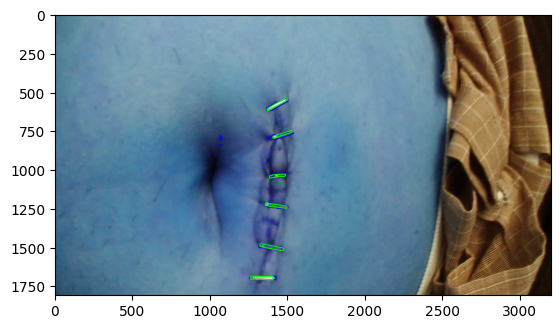

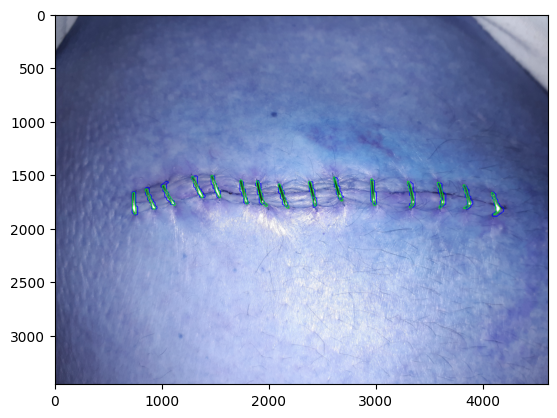

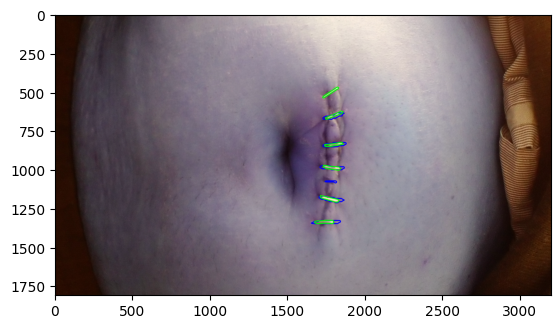

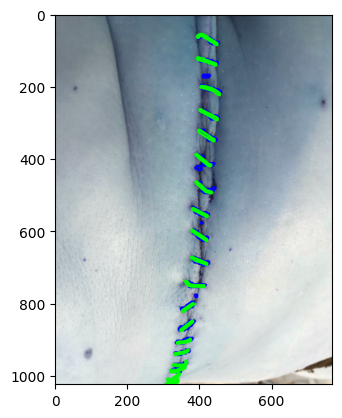

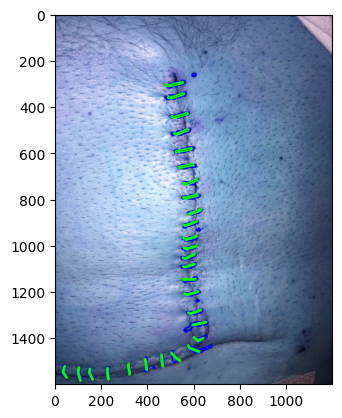

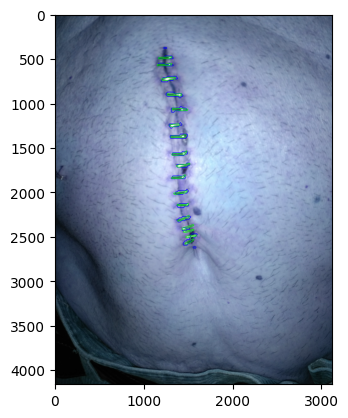

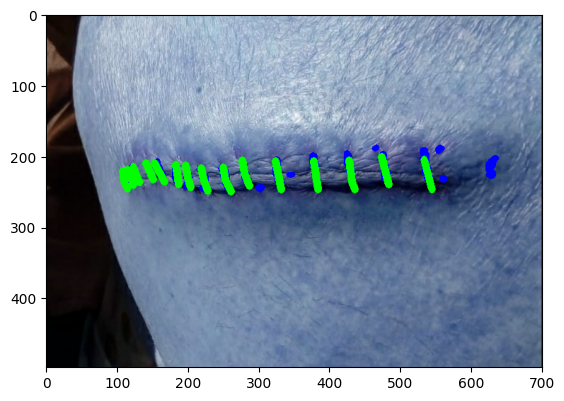

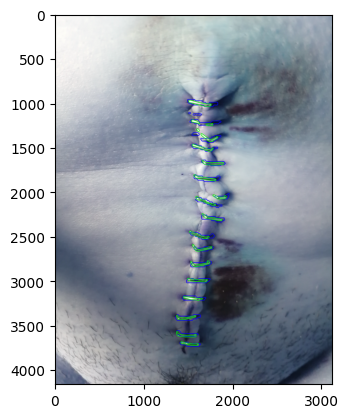

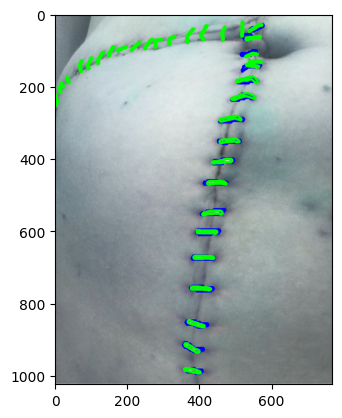

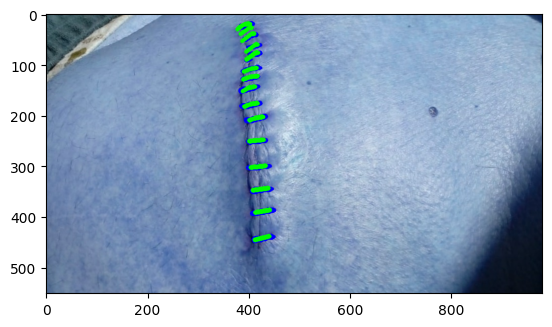

In [17]:
ruta_millors = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment05/alta_resolucio_10_millors'

ruta_imatge = os.path.join(REDSCAR_DATASET_TEST,'IMAGES')
ruta_gts = os.path.join(REDSCAR_DATASET_TEST,'GT_STAPLES_MASK')

# guardam les millors
visualitzacions(model=loaded_model, noms_imatges=nom_millors, ruta_imatges=ruta_imatge, ruta_gt=ruta_gts, input_size=256, ruta_guardar = ruta_millors, titol="millor", qualitat=1)


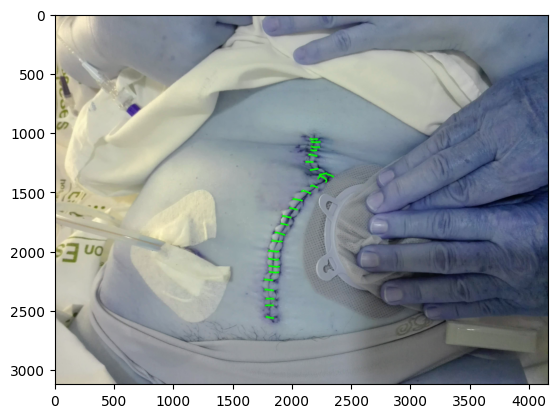

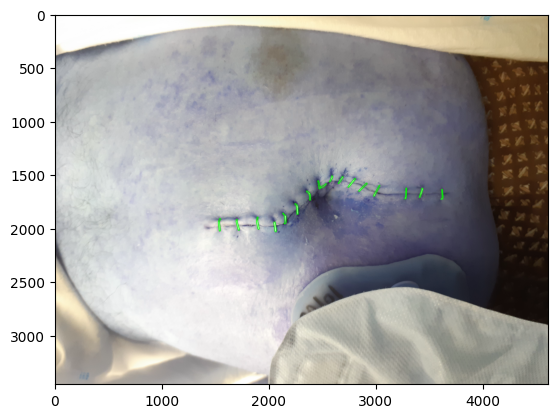

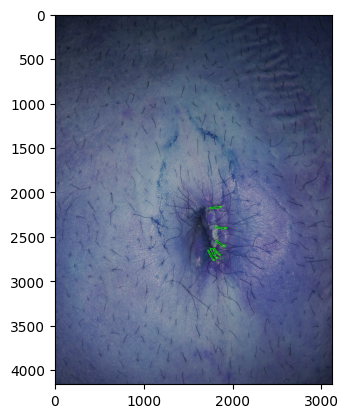

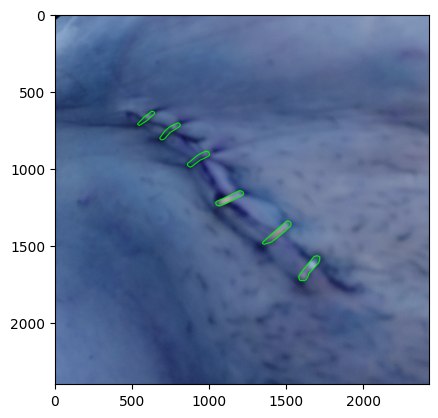

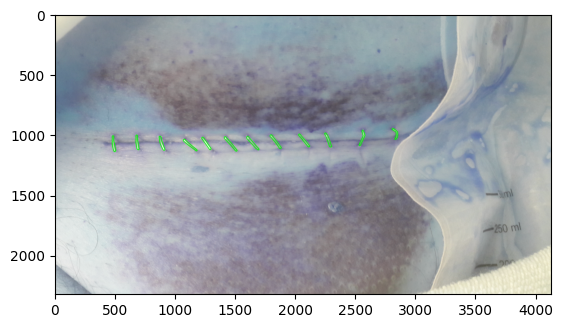

In [18]:
ruta_pitjors = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment05/alta_resolucio_5_pitjors'

# guardam les pitjors
visualitzacions(model=loaded_model, noms_imatges=nom_pitjors, ruta_imatges=ruta_imatge, ruta_gt=ruta_gts, input_size=256, ruta_guardar = ruta_pitjors, titol="pitjor", qualitat=1)


## Filtratge 2: millors i pitjors imatges de baixa resolució

In [19]:
# filtram les imatges d'alta resolució -> df2:
df2 = df[df['nom'].str.endswith('resolution=0.png')]

# eliminam les que NO tenen cap grapa
noms_sense = ['BSmmQo7gZrySCxbaqbqcUrv2F_infection=0_capture=1_resolution=0.png',
             'fEMdP896R7Ns2a6mtbb0uGbpT_infection=0_capture=1_resolution=0.png',
             'YH30nPmh3tokV3aNsPNrFNtpt_infection=0_capture=1_resolution=0.png',
             'fgXrcZ3JaNWgGsJWrjpt8kTi8_infection=0_capture=1_resolution=0.png',
             '2XKzbg86QY1lzFzF6xyk8r49M_infection=0_capture=1_resolution=0.png']
df2 = df2[~df2['nom'].isin(noms_sense)].reset_index(drop=True)

# l'ordenam en funció del coeficient dice
df2_sorted = df2.sort_values(by='DICE',ascending=False).reset_index(drop=True)# ordenem el df de major a menor coef. de dice
                                                       # per a accedir més fàcilment a les imatges que volem seleccionar

print(df2_sorted)

                                                  nom      DICE   JACCARD  \
0   tSBNbbT8NVk7wj1KEn5UVHOtU_infection=0_capture=...  0.806452  0.675676   
1   xIUmdHjGarh1OLf59VEYPVWKw_infection=0_capture=...  0.726210  0.570118   
2   XIIlLL72NJGmdAye6jDJ5O9af_infection=0_capture=...  0.695163  0.532759   
3   5tTSvHZ1t938soPFQt3iHl9mG_infection=0_capture=...  0.681818  0.517241   
4   89Cmrsk0up7FIc0NwQcL5vvwS_infection=0_capture=...  0.675812  0.510360   
5   fsQjP7gdPYnqNWbJACkayeaK8_infection=0_capture=...  0.674208  0.508532   
6   4DW7XoGmJl5dRJv19NByC3bjs_infection=0_capture=...  0.667586  0.501035   
7   xFxXLXh7O8elpSiHESB8UzHt7_infection=0_capture=...  0.661274  0.493958   
8   7PsK2pKVrkofRQKGB6yIyAmqv_infection=0_capture=...  0.660999  0.493651   
9   Cb0NA3WPBx6vM8escc4Am9S5N_infection=0_capture=...  0.657718  0.490000   
10  wqcCQS7lvhb35bOTZj5xuw9Fy_infection=0_capture=...  0.647409  0.478643   
11  FkjbaDe3x5vbXR5g1eAR4jhQM_infection=0_capture=...  0.646707  0.477876   

In [20]:
nom_tots = []
dice_tots = []

# seleccionam les 10 millors
nom_millors = []
for i in range(10):
    nom = df2_sorted.loc[i,"nom"]
    nom_millors.append(nom)
    nom_tots.append(nom)
    dice_tots.append(df2_sorted.loc[i,"DICE"])
    
# seleccionam les 5 pitjors
nom_pitjors = []
n = df2_sorted.shape[0]
# iteram a les 5 darreres files
for i in range(n-5,n):
    nom = df2_sorted.loc[i,"nom"]
    dice_value = df2_sorted.loc[i,"DICE"]
    nom_pitjors.append(nom)
    nom_tots.append(nom)
    dice_tots.append(dice_value)
print(nom_millors)
print(nom_tots) 
print(dice_tots)
resultats_unet2_baixa = pd.DataFrame({'NOM':nom_tots, 'DICE':dice_tots})
# el guardam com un arxiu .csv en la carpeta resultats
RESULTATS_PATH = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment05/unet2_grapes_resultats_baixa.csv'
resultats_unet2_baixa.to_csv(RESULTATS_PATH, index=False)

['tSBNbbT8NVk7wj1KEn5UVHOtU_infection=0_capture=1_resolution=0.png', 'xIUmdHjGarh1OLf59VEYPVWKw_infection=0_capture=1_resolution=0.png', 'XIIlLL72NJGmdAye6jDJ5O9af_infection=0_capture=1_resolution=0.png', '5tTSvHZ1t938soPFQt3iHl9mG_infection=0_capture=1_resolution=0.png', '89Cmrsk0up7FIc0NwQcL5vvwS_infection=0_capture=1_resolution=0.png', 'fsQjP7gdPYnqNWbJACkayeaK8_infection=0_capture=1_resolution=0.png', '4DW7XoGmJl5dRJv19NByC3bjs_infection=0_capture=1_resolution=0.png', 'xFxXLXh7O8elpSiHESB8UzHt7_infection=0_capture=1_resolution=0.png', '7PsK2pKVrkofRQKGB6yIyAmqv_infection=0_capture=1_resolution=0.png', 'Cb0NA3WPBx6vM8escc4Am9S5N_infection=0_capture=1_resolution=0.png']
['tSBNbbT8NVk7wj1KEn5UVHOtU_infection=0_capture=1_resolution=0.png', 'xIUmdHjGarh1OLf59VEYPVWKw_infection=0_capture=1_resolution=0.png', 'XIIlLL72NJGmdAye6jDJ5O9af_infection=0_capture=1_resolution=0.png', '5tTSvHZ1t938soPFQt3iHl9mG_infection=0_capture=1_resolution=0.png', '89Cmrsk0up7FIc0NwQcL5vvwS_infection=0_capture

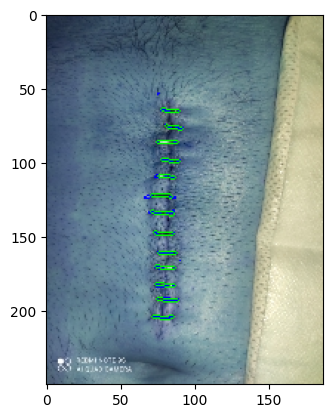

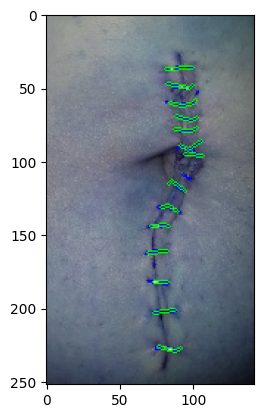

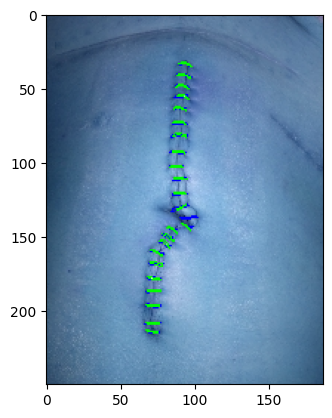

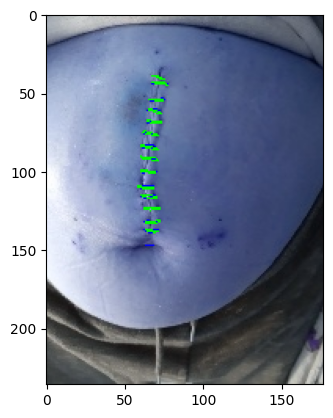

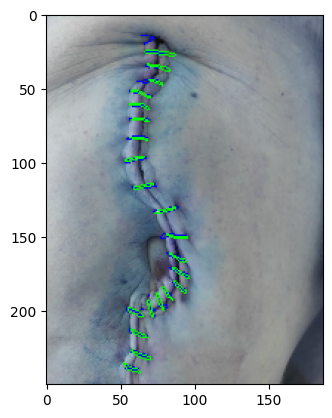

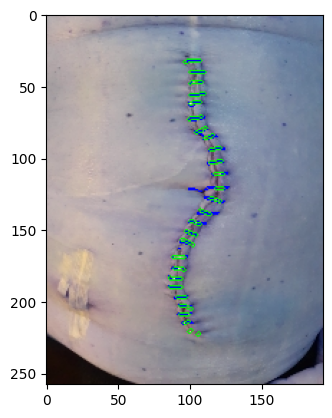

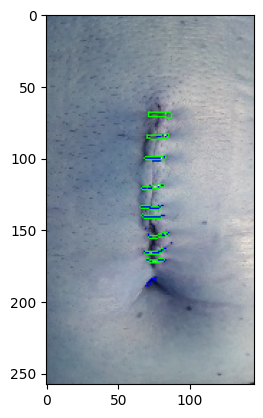

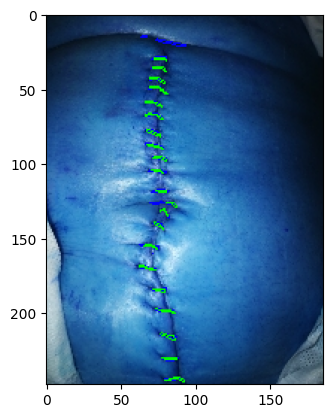

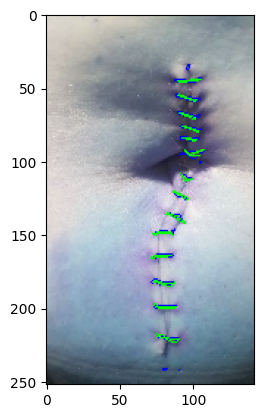

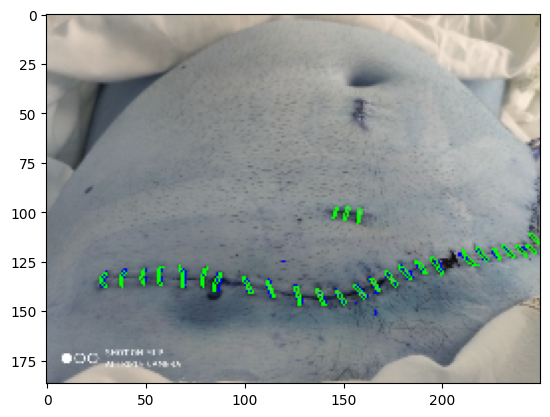

In [21]:
ruta_millors = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment05/baixa_resolucio_10_millors'

# guardam les millors
visualitzacions(model=loaded_model, noms_imatges=nom_millors, ruta_imatges=ruta_imatge, ruta_gt=ruta_gts, input_size=256, ruta_guardar = ruta_millors, titol="millor", qualitat=0)

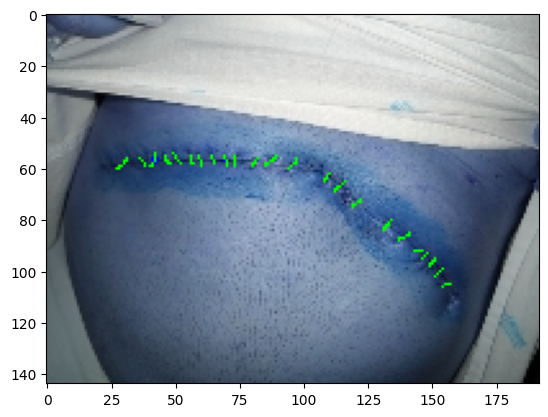

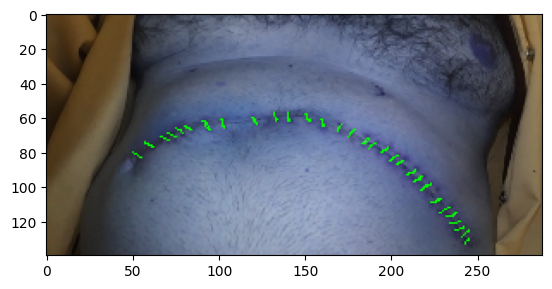

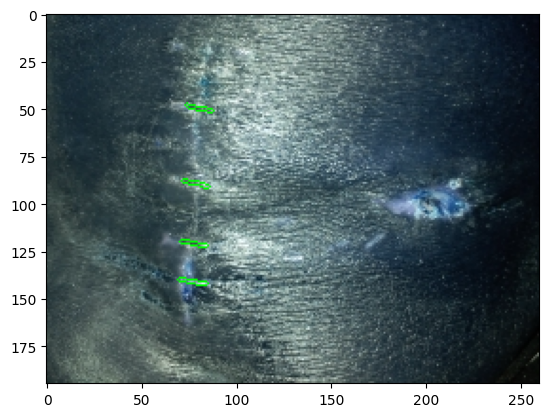

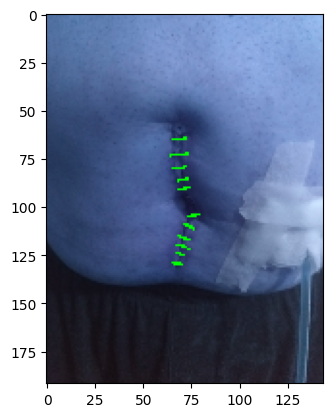

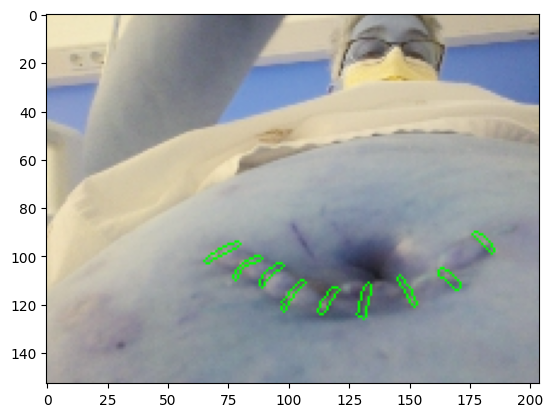

In [22]:
ruta_pitjors = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment05/baixa_resolucio_5_pitjors'

# guardam les pitjors
visualitzacions(model=loaded_model, noms_imatges=nom_pitjors, ruta_imatges=ruta_imatge, ruta_gt=ruta_gts, input_size=256, ruta_guardar = ruta_pitjors, titol="pitjor", qualitat=0)